Здравствуй, дорогой читатель! В данном файле ты можешь увидеть интереснейшее применение анализа данных для работы с данными теннисных матчей и букмекерских котировок. Идея данной работы пришла ко мне после долгих лет игры в теннис и небольшого увлечения ставками. Она состоит в вопросе: являются ли букмекерские котировки "справедливыми"? Отражают ли они реальный расклад перед матем или можно найти какие-либо "провалы рынка"? Здесь сразу надо поправиться и сказать, что коэффициенты на матчи определяют не столько букмекерские конторы (они равзве что задают начальные ставки), а сами игроки, то есть сторона спроса. Сильное давление на котировки может заставить букмекерские конторы значительно снизить их, так как такая ситуация увеличивает вероятность того, что, например, данный матч является договорным, и предоставитель букмекерских услуг может потерять большие суммы, не подстроив ставки. Можно сказать, что к началу матча коэффициенты определены стороной рынкой, и получается, что мой вопрос, выраженный в корректной форме, звучит так: насколько сильно ошибаются игроки на ставках в оценке расклада сил перед теннисными матчами? 

Но как же оценить эту истинный расклад? Как понять, каковы настоящие вероятности победы каждого из игроков перед матчем? Возможно, лет 100 назад мне пришлось бы идти к гадалке, но жизнь не стоит на месте и открывает перед нами новые горизонты. Благодаря лучшим умам мира появился новый способ оценки вероятностей событий (и не только) -  machine learning. С помощью больших массивов данных можно обучить компьютер угадывать вероятности перед матчами о том, будет тот или иной игрок победителем или проигравшим, и использовать это в дальнейшем. Безусловно, важно качество алгоритма, который будет получен, ведь он и определит качество модели.  

Для начала загрузим все необходимые для анализа данных библиотеки.

In [207]:
import scipy.stats as stats
import csv as csv
import numpy as np
import pandas as pd
import seaborn as sns
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
%pylab inline


Populating the interactive namespace from numpy and matplotlib


Далее приступим к работе с данными.

##  Работа со статистическими данными о теннисных матчах

Откроем файл с данными о матчах за 2000-2015 годы и за 2016 год.    
*Данные взяты с https://github.com/JeffSackmann/tennis_atp.

In [208]:
matches = pd.read_csv('all_matches_2000-2015.csv')
matches.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2000-717,Orlando,Clay,32,A,20000501,1,102179,NaN,NaN,...,15.0,13.0,4.0,110.0,59.0,49.0,31.0,17.0,4.0,4.0
1,2000-717,Orlando,Clay,32,A,20000501,2,103602,NaN,Q,...,6.0,0.0,0.0,57.0,24.0,13.0,17.0,10.0,4.0,9.0
2,2000-717,Orlando,Clay,32,A,20000501,3,103387,NaN,NaN,...,0.0,2.0,2.0,65.0,39.0,22.0,10.0,8.0,6.0,10.0
3,2000-717,Orlando,Clay,32,A,20000501,4,101733,NaN,NaN,...,12.0,4.0,6.0,104.0,57.0,35.0,24.0,15.0,6.0,11.0
4,2000-717,Orlando,Clay,32,A,20000501,5,101727,4.0,NaN,...,1.0,0.0,3.0,47.0,28.0,17.0,10.0,8.0,3.0,6.0


In [209]:
tennis2016 = pd.read_csv('atp_matches_2016.csv')

Теперь объединим их и сделаем нумерацию от 0 до числа строк в новом датафрейме.

In [210]:
matches = pd.concat([matches, tennis2016])
matches.index = range(len(matches.index))
matches.tail(2)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
53118,2016-M-DC-2016-WG-PO-SUI-UZB-01,Davis Cup WG PO: SUI vs UZB,Clay,4,D,20160916,4,104797,NaN,NaN,...,8.0,3.0,6.0,169.0,103.0,70.0,34.0,24.0,2.0,7.0
53119,2016-M-DC-2016-WG-PO-SUI-UZB-01,Davis Cup WG PO: SUI vs UZB,Clay,4,D,20160916,5,134472,NaN,NaN,...,8.0,8.0,3.0,114.0,63.0,39.0,26.0,19.0,6.0,14.0


Посмотрим основную информацию о новом датафрейме 'matches':

In [211]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53120 entries, 0 to 53119
Data columns (total 49 columns):
tourney_id            53120 non-null object
tourney_name          53120 non-null object
surface               53002 non-null object
draw_size             53120 non-null int64
tourney_level         53120 non-null object
tourney_date          53120 non-null int64
match_num             53120 non-null int64
winner_id             53120 non-null int64
winner_seed           22156 non-null float64
winner_entry          6192 non-null object
winner_name           53120 non-null object
winner_hand           53108 non-null object
winner_ht             49751 non-null float64
winner_ioc            53120 non-null object
winner_age            53102 non-null float64
winner_rank           52057 non-null float64
winner_rank_points    52057 non-null float64
loser_id              53120 non-null int64
loser_seed            11899 non-null float64
loser_entry           10390 non-null object
loser_name 

Сделаем новые, более репрезентативные и информативные статистические показатели игроков за матч:

In [212]:
matches['w_Prct1stIn'] = matches['w_1stIn'] / matches['w_svpt']
matches['w_Prct1stWon'] = matches['w_1stWon'] / matches['w_1stIn']
matches['w_Prct_ace'] = matches['w_ace'] / matches['w_svpt']
matches['w_bpWon'] = matches['l_bpFaced'] - matches['l_bpSaved']
matches['w_1stRetpt'] = matches['l_1stIn']
matches['w_1stRetptWon'] = matches['l_1stIn'] - matches['l_1stWon']
matches['w_Prct1stRetptWon'] = matches['w_1stRetptWon'] / matches['l_1stIn']

matches['l_Prct1stIn'] = matches['l_1stIn'] / matches['l_svpt']
matches['l_Prct1stWon'] = matches['l_1stWon'] / matches['l_1stIn']
matches['l_Prct_ace'] = matches['l_ace'] / matches['l_svpt']
matches['l_bpWon'] = matches['w_bpFaced'] - matches['w_bpSaved']
matches['l_1stRetpt'] = matches['w_1stIn']
matches['l_1stRetptWon'] = matches['w_1stIn'] - matches['w_1stWon']
matches['l_Prct1stRetptWon'] = matches['l_1stRetptWon'] / matches['w_1stIn']



Поменяем порядок колонок для лучшей читаемости датафрейма:

In [213]:
matches = matches[['winner_name', 'score', 'loser_name','tourney_name', 'tourney_date', 'surface', 'round', 'minutes',
                   'winner_rank', 'loser_rank',
    'draw_size', 'best_of', 'tourney_level', 'match_num', 'tourney_id',
            'winner_id', 'winner_seed', 'winner_entry', 
            'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
            'winner_rank_points', 'loser_id', 'loser_seed',
       'loser_entry',  'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age',  'loser_rank_points',
            'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon',
            'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 
        'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
       'l_bpFaced', 
            'w_Prct1stIn', 'w_Prct1stWon', 'w_Prct_ace', 'w_bpWon', 'w_1stRetpt', 'w_1stRetptWon', 'w_Prct1stRetptWon',
        'l_Prct1stIn', 'l_Prct1stWon', 'l_Prct_ace', 'l_bpWon', 'l_1stRetpt', 'l_1stRetptWon',
       'l_Prct1stRetptWon']]



В данном датафрейме в колонках 'winner_name' и 'loser_name' можно увидеть полные имя и фамилию выигравшего и проигравшего игроков соответственно. Создадим новые колонки 'Winner' и 'Loser' с фамилией, первой буквой имени игрока и точкой после неё. В дальнейшем мы увидим, что это нам очень пригодится. 

In [214]:
matches['Winner'] = matches['winner_name'].apply(lambda s: s.split()[-1] + ' ' + s[0] + '.')

matches['Loser'] = matches['loser_name'].apply(lambda s: s.split()[-1] + ' ' + s[0] + '.')

Посмотрим, как выглядят даты турниров в данном датафрейме:

In [215]:
matches['tourney_date'].head(5)

0    20000501
1    20000501
2    20000501
3    20000501
4    20000501
Name: tourney_date, dtype: int64

Очень странный, неудобный и нечитаемый формат. Переделаем его в клаассический формат даты для работы в pandas 'datetime'. Это также поможет нам для анализа данных в дальнейшем. На всякий случай выделим день, месяц и год тоже.    
Комментарий: важно понимать, что здесь указаны даты НАЧАЛА ТУРНИРОВ, а не самих матчей.

In [216]:
matches['Tournament Date'] = pd.to_datetime(matches['tourney_date'], format='%Y%m%d')

matches['Year'] = np.int_(matches['Tournament Date'].dt.year)
matches['Month'] = np.int_(matches['Tournament Date'].dt.month)
matches['Day'] = np.int_(matches['Tournament Date'].dt.day)

matches[['Tournament Date', 'Year', 'Month', 'Day']].head()

,Tournament Date,Year,Month,Day
0,2000-05-01,2000,5,1
1,2000-05-01,2000,5,1
2,2000-05-01,2000,5,1
3,2000-05-01,2000,5,1
4,2000-05-01,2000,5,1


Проверим наше преобразование дат и посмотрим на некоторые колонки датафрейма:

In [217]:
matches[['winner_name', 'score', 'loser_name', 'tourney_name', 'round', 'Tournament Date', 'tourney_date']].head()

,winner_name,score,loser_name,tourney_name,round,Tournament Date,tourney_date
0,Antony Dupuis,3-6 7-6(6) 7-6(4),Andrew Ilie,Orlando,R32,2000-05-01,20000501
1,Fernando Gonzalez,6-2 7-5,Cecil Mamiit,Orlando,R32,2000-05-01,20000501
2,Paradorn Srichaphan,6-1 6-3,Sebastien Lareau,Orlando,R32,2000-05-01,20000501
3,Jan Siemerink,4-6 6-2 7-5,Justin Gimelstob,Orlando,R32,2000-05-01,20000501
4,Jason Stoltenberg,6-1 6-4,Alex Lopez Moron,Orlando,R32,2000-05-01,20000501


Ради интереса посмотрим, какие вообще раунды турниров представлены в нашем датафрейме:

In [218]:
matches['round'].value_counts()

R32     16867
R16      8868
R64      8208
RR       5990
R128     5312
QF       4451
SF       2266
F        1153
BR          5
Name: round, dtype: int64

In [219]:
matches[['Winner', 'score', 'Loser', 'Tournament Date']].head()

,Winner,score,Loser,Tournament Date
0,Dupuis A.,3-6 7-6(6) 7-6(4),Ilie A.,2000-05-01
1,Gonzalez F.,6-2 7-5,Mamiit C.,2000-05-01
2,Srichaphan P.,6-1 6-3,Lareau S.,2000-05-01
3,Siemerink J.,4-6 6-2 7-5,Gimelstob J.,2000-05-01
4,Stoltenberg J.,6-1 6-4,Moron A.,2000-05-01


После всех преобразований посмотрим на информацию о датафрейме, чтобы понимать, с чем нам теперь придётся работать:

In [220]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53120 entries, 0 to 53119
Data columns (total 69 columns):
winner_name           53120 non-null object
score                 53119 non-null object
loser_name            53120 non-null object
tourney_name          53120 non-null object
tourney_date          53120 non-null int64
surface               53002 non-null object
round                 53120 non-null object
minutes               46132 non-null float64
winner_rank           52057 non-null float64
loser_rank            51350 non-null float64
draw_size             53120 non-null int64
best_of               53120 non-null int64
tourney_level         53120 non-null object
match_num             53120 non-null int64
tourney_id            53120 non-null object
winner_id             53120 non-null int64
winner_seed           22156 non-null float64
winner_entry          6192 non-null object
winner_hand           53108 non-null object
winner_ht             49751 non-null float64
winner_ioc  

Отлично! Новый датафрейм стал более читаемым и информативным.

## Графики: matches
### Визуализируем данные, которые есть в данном датафрейме

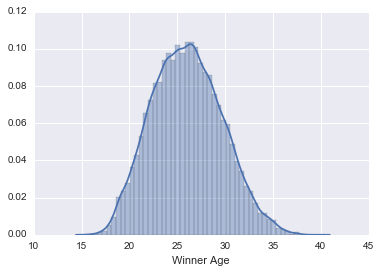

In [221]:
sns.distplot(matches['winner_age'].dropna(), axlabel='Winner Age')

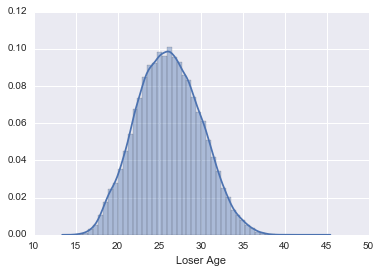

In [222]:
sns.distplot(matches['loser_age'].dropna(), axlabel='Loser Age')

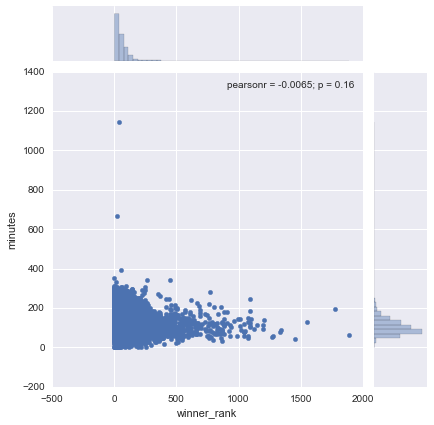

In [223]:
sns.jointplot(matches['winner_rank'].dropna(), matches['minutes'].dropna())

Посмотрим, какие игроки за 2000-2016 гг. выиграли больше всех матчей:

In [224]:
best_winners = matches['winner_name'].value_counts()[:10]
print(best_winners)

Roger Federer        1075
Rafael Nadal          814
Novak Djokovic        761
David Ferrer          698
Andy Murray           638
Andy Roddick          614
Tomas Berdych         582
Lleyton Hewitt        564
Tommy Robredo         525
Nikolay Davydenko     484
Name: winner_name, dtype: int64


Конечно, данный список можно оформить в более красивом виде:

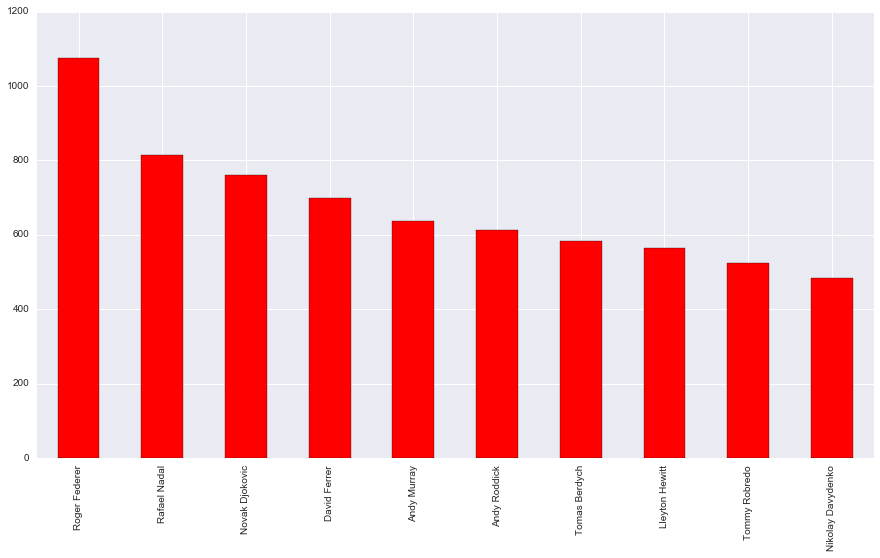

In [225]:
best_winners.plot(kind='bar', figsize=(15,8), color='red')

Теперь посмотрим на проигравших:

In [226]:
best_losers = matches['loser_name'].value_counts()[:10]
print(best_losers)

Mikhail Youzhny          384
Feliciano Lopez          383
Jarkko Nieminen          349
Tommy Robredo            345
Nikolay Davydenko        338
Fernando Verdasco        336
David Ferrer             334
Andreas Seppi            332
Jurgen Melzer            332
Philipp Kohlschreiber    313
Name: loser_name, dtype: int64


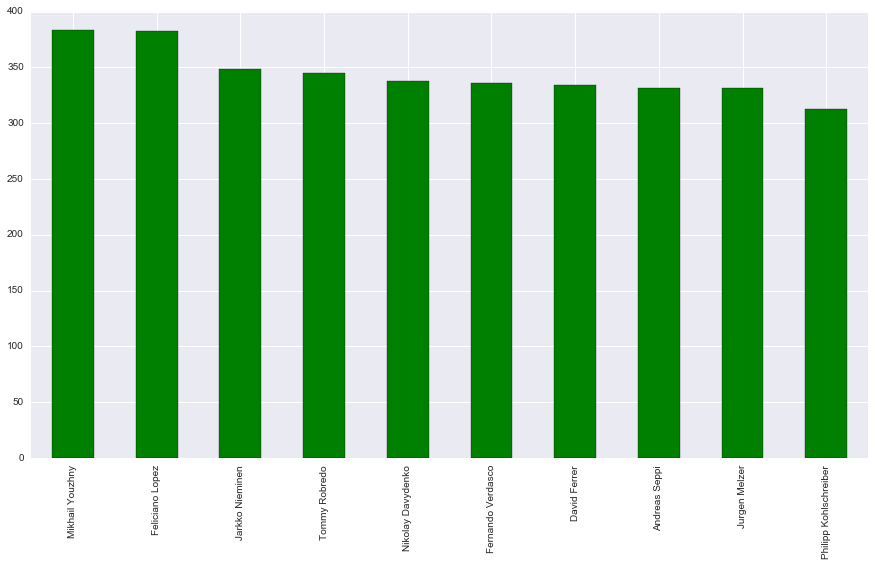

In [227]:
best_losers.plot(kind='bar', figsize=(15,8), color='g')

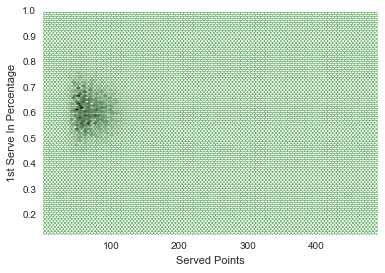

In [228]:
import numpy as np
import matplotlib.pyplot as plt

x = matches.w_svpt
y = matches.w_Prct1stIn

plt.xlabel('Served Points')
plt.ylabel('1st Serve In Percentage')

plt.hexbin(x, y, edgecolors='g')

plt.show()


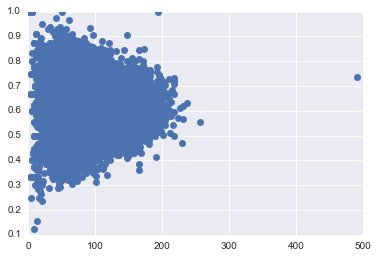

In [229]:
x = matches.w_svpt
y = matches.w_Prct1stIn 
plot(x, y, 'o')

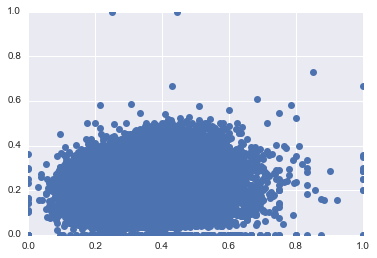

In [230]:
x = matches.w_Prct1stRetptWon
y = matches.l_Prct1stRetptWon
plot(x, y, 'o')

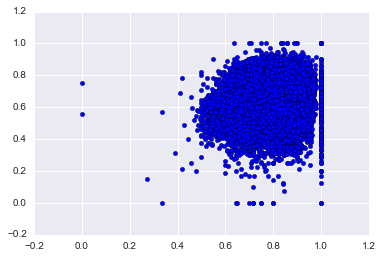

In [231]:
x = matches.w_Prct1stWon
y = matches.l_Prct1stWon
plt.scatter(x, y)

Графиков будет больше!

## Работа с букмекерскими ставками на теннисные матчи

Прочитаем файлы со ставками за 2001-2016 года.    

*Данные взяты с http://www.tennis-data.co.uk/alldata.php.

In [232]:
bets_2001 = pd.read_excel('2001.xls')
bets_2002 = pd.read_excel('2002.xls')
bets_2003 = pd.read_excel('2003.xls')
bets_2004 = pd.read_excel('2004.xls')
bets_2005 = pd.read_excel('2005.xls')
bets_2006 = pd.read_excel('2006.xls')
bets_2007 = pd.read_excel('2007.xls')
bets_2008 = pd.read_excel('2008.xls')
bets_2009 = pd.read_excel('2009.xls')
bets_2010 = pd.read_excel('2010.xls')
bets_2011 = pd.read_excel('2011.xls')
bets_2012 = pd.read_excel('2012.xls')
bets_2013 = pd.read_excel('2013.xls')
bets_2014 = pd.read_excel('2014.xls')
bets_2015 = pd.read_excel('2015.xls')
bets_2016 = pd.read_excel('2016.xls')

Объединим все датафреймы со ставками в один:

In [233]:
all_bets = pd.concat([bets_2001, bets_2002, bets_2003, bets_2004, bets_2005, bets_2006, bets_2007, bets_2008, bets_2009,
          bets_2010, bets_2011, bets_2012, bets_2013, bets_2014, bets_2015, bets_2016])
all_bets.head()

,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,Venue,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets
0,1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,6.0,6,6,NaN,NaN,NaN,18.0,Clement A.,2.0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,NaN,81.0,Goldstein P.,2.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,NaN,23.0,Haas T.,2.0
3,1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,6.0,7,NaN,NaN,NaN,NaN,10.0,Henman T.,2.0
4,1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.3,1.28,...,NaN,6.0,6,NaN,NaN,NaN,NaN,7.0,Hewitt L.,2.0


In [234]:
all_bets.tail()

,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,Venue,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets
2621,66,3.68,1.28,NaN,NaN,3.75,1.28,3.0,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,11185.0,1.0,Murray A.,2.0
2622,66,1.56,2.41,NaN,NaN,1.57,2.37,3.0,NaN,NaN,...,NaN,3.0,6,6,NaN,NaN,3450.0,7.0,Cilic M.,2.0
2623,66,4.28,1.22,NaN,NaN,4.50,1.20,3.0,NaN,NaN,...,NaN,5.0,7,7,NaN,NaN,11185.0,1.0,Murray A.,2.0
2624,66,4.20,1.23,NaN,NaN,4.33,1.22,3.0,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,10780.0,2.0,Djokovic N.,2.0
2625,66,1.50,2.60,NaN,NaN,1.53,2.50,3.0,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,11185.0,1.0,Murray A.,2.0


In [235]:
len(all_bets.index)

36311

Выше мы видим очень странную нумерацию: конец датафрейма заканчивается на номере 2625, хотя число строк в датафрейме равно 36311.    
Чтобы исправить это недочёт, переиндексируем строки:

In [236]:
all_bets.index = range(len(all_bets.index))

In [237]:
all_bets.tail()

,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,Venue,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets
36306,66,3.68,1.28,NaN,NaN,3.75,1.28,3.0,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,11185.0,1.0,Murray A.,2.0
36307,66,1.56,2.41,NaN,NaN,1.57,2.37,3.0,NaN,NaN,...,NaN,3.0,6,6,NaN,NaN,3450.0,7.0,Cilic M.,2.0
36308,66,4.28,1.22,NaN,NaN,4.50,1.20,3.0,NaN,NaN,...,NaN,5.0,7,7,NaN,NaN,11185.0,1.0,Murray A.,2.0
36309,66,4.20,1.23,NaN,NaN,4.33,1.22,3.0,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,10780.0,2.0,Djokovic N.,2.0
36310,66,1.50,2.60,NaN,NaN,1.53,2.50,3.0,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,11185.0,1.0,Murray A.,2.0


Так лучше!

Посмотрим информацию о датафрейме 'all_bets':

In [238]:
all_bets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36311 entries, 0 to 36310
Data columns (total 57 columns):
ATP           36311 non-null int64
AvgL          10480 non-null float64
AvgW          10480 non-null float64
B&WL          1097 non-null float64
B&WW          1097 non-null float64
B365L         30497 non-null float64
B365W         30493 non-null float64
Best of       36104 non-null float64
CBL           17507 non-null float64
CBW           17507 non-null float64
Comment       36104 non-null object
Court         36311 non-null object
Date          36104 non-null datetime64[ns]
EXL           26384 non-null float64
EXW           26379 non-null object
GBL           5055 non-null float64
GBW           5055 non-null float64
IWL           13358 non-null float64
IWW           13358 non-null float64
L1            35931 non-null float64
L2            35578 non-null object
L3            16643 non-null object
L4            3234 non-null float64
L5            1245 non-null float64
LBL      

Узнаем ради любопытства, какие раунды представлены в этом датафрейме:

In [239]:
all_bets['Round'].value_counts() #поэтому датасеты нельзя объединить по раундам

1st Round        16788
2nd Round         9904
Quarterfinals     3388
3rd Round         2568
Semifinals        1721
The Final          859
4th Round          600
Round Robin        276
Name: Round, dtype: int64

А теперь посмотрим на даты:

In [240]:
all_bets['Date'].head()

0   2001-01-01
1   2001-01-01
2   2001-01-01
3   2001-01-01
4   2001-01-01
Name: Date, dtype: datetime64[ns]

Ух ты! Они представлены ровно в том формате, в который мы переделывали даты из датафрейма 'matches' - в формате 'datetime'.

Создадим колонки с годом, месяцем и днём. Вдруг пригодятся!

In [241]:
all_bets['Year'] = np.int_(all_bets['Date'].dt.year)
all_bets['Month'] = np.int_(all_bets['Date'].dt.month)
all_bets['Day'] = np.int_(all_bets['Date'].dt.day)

all_bets[['Date', 'Year', 'Month', 'Day']].head()

,Date,Year,Month,Day
0,2001-01-01,2001,1,1
1,2001-01-01,2001,1,1
2,2001-01-01,2001,1,1
3,2001-01-01,2001,1,1
4,2001-01-01,2001,1,1


В информации о датасете можно было найти колонку 'Start Date'. Что за информация находится в ней? Дата начала турнира, как в датафрейме 'matches', или что-то еще? Посмотрим, много ли значений в ней есть вообще:

In [242]:
all_bets['Start Date'].describe()

count                     207
unique                     37
top       2003-07-07 00:00:00
freq                        9
first     2002-12-30 00:00:00
last      2003-11-10 00:00:00
Name: Start Date, dtype: object

Всего 207 из 36310. Неинформативный признак, получается.    

Посмотрим ещё на пару подозрительных признаков.

In [243]:
all_bets['Players'].describe()

count    207.000000
mean      44.057971
std       24.787965
min        8.000000
25%       32.000000
50%       32.000000
75%       48.000000
max      128.000000
Name: Players, dtype: float64

In [244]:
all_bets['Venue'].describe()

count      207
unique      69
top       Umag
freq         3
Name: Venue, dtype: object

Колонки 'Players', 'Start Date' и 'Venue' практически не несует в себе никакой информации, что позже может вызвать проблемы, когда придётся заполнять ячейкие с отсутствующими значениями ('NaN'). Удалим их из датасета:

In [245]:
all_bets = all_bets.drop(['Players', 'Start Date', 'Venue'], axis=1)

Теперь посмотрим на ещё один подозрительный признак: 'Court':

In [246]:
all_bets['Court'].value_counts()

Outdoor    29789
Indoor      6522
Name: Court, dtype: int64

Его удалять не будем, так как он несёт информацию о каждом матче, был он сыгран на улице (outdoor) или в помещении (indoor).

Выделим в отдельный датасет ставки на победителей в разных букмекерских конторах, чтобы поработать с ними:

In [247]:
winner_bets = all_bets[['B365W','CBW', 'GBW','IWW', 'SBW', 'B&WW', 'EXW', 'LBW', 'PSW', 'UBW','SJW']]
winner_bets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36311 entries, 0 to 36310
Data columns (total 11 columns):
B365W    30493 non-null float64
CBW      17507 non-null float64
GBW      5055 non-null float64
IWW      13358 non-null float64
SBW      5424 non-null float64
B&WW     1097 non-null float64
EXW      26379 non-null object
LBW      15719 non-null float64
PSW      24202 non-null float64
UBW      10672 non-null float64
SJW      7747 non-null float64
dtypes: float64(10), object(1)
memory usage: 3.0+ MB


То же самое проделаем со ставками на проигравших:

In [248]:
loser_bets = all_bets[['B365L','CBL', 'GBL','IWL', 'SBL', 'B&WL', 'EXL', 'LBL', 'PSL', 'UBL','SJL']]
loser_bets.head()

,B365L,CBL,GBL,IWL,SBL,B&WL,EXL,LBL,PSL,UBL,SJL
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.3,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сделаем полностью заполненную значениями максимальной котировки на победителя колонку:

In [249]:
all_bets['MaxW'] = winner_bets.max(axis=1)
all_bets['MaxW'].head()

0     NaN
1     NaN
2    1.12
3     NaN
4    1.28
Name: MaxW, dtype: float64

Аналогично сделаем для проигравшего:

In [250]:
all_bets['MaxL'] = loser_bets.max(axis=1)
all_bets['MaxL'].head()

0    NaN
1    NaN
2    4.0
3    NaN
4    3.8
Name: MaxL, dtype: float64

Теперь вычислим среднюю котировку из представленных в датафрейме для победителя: 

In [251]:
all_bets['AvgW'] = winner_bets.mean(axis=1)
all_bets['AvgW'].head()

0     NaN
1     NaN
2    1.11
3     NaN
4    1.20
Name: AvgW, dtype: float64

И проигравшего:

In [252]:
all_bets['AvgL'] = loser_bets.mean(axis=1)
all_bets['AvgL'].head()

0     NaN
1     NaN
2    3.75
3     NaN
4    3.55
Name: AvgL, dtype: float64

Теперь вычислим такой статистических показатель, как дисперсия котировок.     
Для победителя:

In [253]:
all_bets['VarW'] = winner_bets.var(axis=1)
all_bets['VarW'].head()

0       NaN
1       NaN
2    0.0002
3       NaN
4    0.0128
Name: VarW, dtype: float64

Для проигравшего:

In [254]:
all_bets['VarL'] = loser_bets.var(axis=1)
all_bets['VarL'].head()

0      NaN
1      NaN
2    0.125
3      NaN
4    0.125
Name: VarL, dtype: float64

Посмотрим на новые данные в совокупности с некоторыми старыми:

In [255]:
all_bets[['Winner', 'Wsets', 'Lsets', 'Loser', 'AvgW', 'AvgL', 'VarW', 'VarL', 'Tournament', 'Location', 'Round', 'Year']].head()

,Winner,Wsets,Lsets,Loser,AvgW,AvgL,VarW,VarL,Tournament,Location,Round,Year
0,Clement A.,2.0,1,Gaudenzi A.,NaN,NaN,NaN,NaN,AAPT Championships,Adelaide,1st Round,2001
1,Goldstein P.,2.0,0,Jones A.,NaN,NaN,NaN,NaN,AAPT Championships,Adelaide,1st Round,2001
2,Haas T.,2.0,0,Smith L.,1.11,3.75,0.0002,0.125,AAPT Championships,Adelaide,1st Round,2001
3,Henman T.,2.0,0,Rusedski G.,NaN,NaN,NaN,NaN,AAPT Championships,Adelaide,1st Round,2001
4,Hewitt L.,2.0,0,Arthurs W.,1.20,3.55,0.0128,0.125,AAPT Championships,Adelaide,1st Round,2001


Посмотрим, как выглядят признаки 'Wsets' и 'Lsets': 

In [256]:
all_bets[['Winner', 'Wsets', 'Lsets', 'Loser', 'Date', 'Year']].head()

,Winner,Wsets,Lsets,Loser,Date,Year
0,Clement A.,2.0,1,Gaudenzi A.,2001-01-01,2001
1,Goldstein P.,2.0,0,Jones A.,2001-01-01,2001
2,Haas T.,2.0,0,Smith L.,2001-01-01,2001
3,Henman T.,2.0,0,Rusedski G.,2001-01-01,2001
4,Hewitt L.,2.0,0,Arthurs W.,2001-01-01,2001


Переведём значения выигранных победителем сетов в целые числа, чтобы нас ничего не смущало:

In [257]:
all_bets['Wsets'] = np.int_(all_bets['Wsets'])
all_bets['Wsets'][:5]

0    2
1    2
2    2
3    2
4    2
Name: Wsets, dtype: int32

In [258]:
all_bets.tail()

,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,W5,WPts,WRank,Winner,Wsets,Year,Month,Day,VarW,VarL
36306,66,3.6525,1.293333,NaN,NaN,3.75,1.28,3.0,NaN,NaN,...,NaN,11185.0,1.0,Murray A.,2,2016,11,18,0.000233,0.056025
36307,66,1.5525,2.446667,NaN,NaN,1.57,2.37,3.0,NaN,NaN,...,NaN,3450.0,7.0,Cilic M.,2,2016,11,18,0.004633,0.002292
36308,66,4.2525,1.230000,NaN,NaN,4.50,1.20,3.0,NaN,NaN,...,NaN,11185.0,1.0,Murray A.,2,2016,11,19,0.000700,0.179692
36309,66,4.2400,1.230000,NaN,NaN,4.33,1.22,3.0,NaN,NaN,...,NaN,10780.0,2.0,Djokovic N.,2,2016,11,19,0.000300,0.117467
36310,66,1.4825,2.633333,NaN,NaN,1.53,2.50,3.0,NaN,NaN,...,NaN,11185.0,1.0,Murray A.,2,2016,11,20,0.015833,0.005625


In [259]:
all_bets['Series'].value_counts()

International                10490
Grand Slam                    6616
ATP250                        5571
Masters                       4616
International Gold            3286
Masters 1000                  2835
ATP500                        2104
International Series           538
Masters Cup                    195
International Series Gold       27
Tennis Masters Series           27
Year-End Championship            3
World Team Cup                   3
Name: Series, dtype: int64

И напоследок посмотрим на информацию о получившемся датафрейме со ставками:

In [260]:
all_bets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36311 entries, 0 to 36310
Data columns (total 59 columns):
ATP           36311 non-null int64
AvgL          35195 non-null float64
AvgW          35193 non-null float64
B&WL          1097 non-null float64
B&WW          1097 non-null float64
B365L         30497 non-null float64
B365W         30493 non-null float64
Best of       36104 non-null float64
CBL           17507 non-null float64
CBW           17507 non-null float64
Comment       36104 non-null object
Court         36311 non-null object
Date          36104 non-null datetime64[ns]
EXL           26384 non-null float64
EXW           26379 non-null object
GBL           5055 non-null float64
GBW           5055 non-null float64
IWL           13358 non-null float64
IWW           13358 non-null float64
L1            35931 non-null float64
L2            35578 non-null object
L3            16643 non-null object
L4            3234 non-null float64
L5            1245 non-null float64
LBL      

## Графики: all_bets

Построим график квадрата разности очков победителя и проигравшего и дисперсии ставки на выигрыш победителя матча:

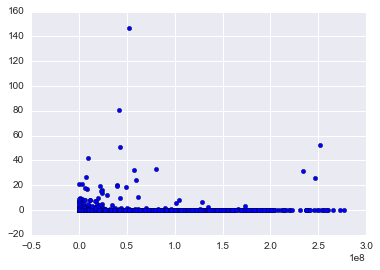

In [261]:
plt.scatter((all_bets['WPts']-all_bets['LPts'])**2, all_bets['VarW'])

Графиков будет больше!

## Соединение датафреймов со статистикой матчей и ставками

Чтобы сделать данное действие, стоит иметь в виду, что:
1. В одном турнире два игрока могут встретиться в одиночном разряде только один раз
2. Каждый турнир проходит лишь раз в году
3. Турниры Большого шлема длятся 2 недели, остальные - неделю

Таким образом, чтобы понять, что два набора данных относятся к одному матчу, нужно проверить лишь сопвпадение имён победителя ('Winner') и проигравшего ('Loser'), года и названия турнира. Но всё же стоит проверить, являются ли, например, названия одних и тех же турниров одинаковыми в обоих датафреймах?

Случайным образом выберем строку и датафрейма 'matches' - 25506. 

In [262]:
Question = matches[25505:25507]
Question[['Winner', 'Loser', 'tourney_name', 'Year']]

,Winner,Loser,tourney_name,Year
25505,Karlovic I.,Hartfield D.,Houston,2007
25506,Melzer J.,Hanescu V.,Houston,2007


Обратим внимание на название турнира  - 'Houston'. Есть вероятность, что в датафрейме со ставками данный турнир назван каким-то более специфичным способом. Проверим:

In [263]:
Houston = all_bets[(all_bets['Winner'] == 'Melzer J.') & (all_bets['Loser'] == 'Hanescu V.') & (all_bets['Year'] == 2007)]
Houston['Tournament']

18234    U.S. Men's Clay Court Championships
Name: Tournament, dtype: object

Оказывается, что так и есть. Посмотрим, а какие вообще названия турниров встречаются наиболее часто в обоих датафреймах. Предположим, что наиболее встречающиеся турниры в обоих датафреймах должны быть примерно одними и теми же, но могут быть названы по-разному.

In [264]:
matches['tourney_name'].value_counts()[:12]

Roland Garros           2159
Wimbledon               2159
Australian Open         2159
US Open                 2032
Miami Masters           1615
Indian Wells Masters    1487
Rome Masters             991
Cincinnati Masters       991
Monte Carlo Masters      991
Canada Masters           983
Barcelona                903
Queen's Club             825
Name: tourney_name, dtype: int64

In [265]:
all_bets['Tournament'].value_counts()[:12]

Wimbledon                                     1651
Australian Open                               1651
French Open                                   1651
US Open                                       1651
Monte Carlo Masters                            763
Sony Ericsson Open                             665
Western & Southern Financial Group Masters     637
Pacific Life Open                              601
Hamburg TMS                                    488
NASDAQ-100 Open                                475
BNP Paribas Open                               475
Mercedes Cup                                   463
Name: Tournament, dtype: int64

Как мы видим, названия трёх турниров Большого шлема (Wimbledon, Australian Open и US Open) совпадают. В то же время, Roland Garros и French Open - это один и тот же турнир (четвёртый турнир Большого шлема), то есть соединить матчи этого соревнования не получится, что приведёт к значительной потере информации (1651 матч на грунте). Более того, можно заметить тенденцию, что в датафрейме 'matches' турниры часто носят названия городов, в которых они проводятся, тогда как в 'all_bets' в названиях чемпионатов можно увидеть имена их спонсоров: Sony Ericsson, BNP Paibas, Mercedes, что приводит к большому число несовпадающих названий турниров.

Таким образом, равенство названия турниров - плохое условие для соединение датафреймов.

Можно было бы соединять матчи, пользуясь условием равенства дат матчей. Но, как уже можно было видеть, в датафрейме 'matches' есть только даты начала матчей турниров, тогда как в датафрейме 'all_bets' - даты самих матчей. Но, на самом деле, такие данные мы можем обратить в преимущество, воспользовавшисть фактом №3 о теннисных матчах.

### Соединение датафреймов с использованием имён победителя и проигравшего и дат датасетов    


Сначала объединим датафреймы 'matches' и 'all_bets' с помощью функции merge. В её скобках записаны названия объединяемых датафреймов, равенство on означает признаки, на основе которых будет произведено объединение, how - какие образом (с помощью объединения, пересечения или других способов; используем inner - пересечение).

In [266]:
matches_bets = pd.merge(matches, all_bets, on=['Winner', 'Loser'], how="inner")
matches_bets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77195 entries, 0 to 77194
Columns: 126 entries, winner_name to VarL
dtypes: datetime64[ns](2), float64(80), int32(7), int64(7), object(30)
memory usage: 72.7+ MB


Теперь у нас есть датафрейм со всеми матчами, где совпали указания победителя и проигравшего в обоих датафреймах. Очевидно, что такой датафрейм не учитывет других данных о матче, что значительно снижает точность объединения. 

Для улучшения датафрейма, который мы потом будет использовать для машинного обучения, сделаем следущие действия:
1. Создадим признак 'date_difference', показывающий разницу между датой турнирного матча и датой начала турнира

2. Создадим два дополнительных признака:
   * KEEP_IN_PLACE_14: равен $1$, если разность дат 'date_difference' лежит на отрезке $[0;14]$, и $0$, если иначе. Данный признак пригодится для турниров Большого шлема
   * KEEP_IN_PLACE_7: равен $1$, если разность дат 'date_difference' лежит на отрезке $[0;7]$, и $0$, если иначе. Данный признак пригодится для остальных турниров
   
   Таким образом созданные признаки проверяют, входит ли матч с конкретной датой в сроки проведения турнира.
   
3. Далее преобразуем датафрейм 'matches_bets' так, чтобы разность между датой матча и датой начала турнира лежала на отрезке $[0;14]$ и матч входил в серию турниров Большого шлема или же разность между датой матча и датой начала турнира лежала на отрезке $[0;7]$ и матч принадлежал любой серии турниров. 

4. Отсортируем получивишийся датафрейм по дате в порядке возрастания (от старых матчей к всё более новым) для более удобной работы с ним

5. Отобразим получившийся датафрейм, прдемонстировав несколько выбранных признаков

In [267]:
matches_bets['date_difference'] = matches_bets['Date'] - matches_bets['Tournament Date']

matches_bets['KEEP_IN_PLACE_14'] = matches_bets['date_difference'].apply(lambda x: 1 if x.days<=14 and x.days>=0 else 0)
matches_bets['KEEP_IN_PLACE_7'] = matches_bets['date_difference'].apply(lambda x: 1 if x.days<=7 and x.days>=0 else 0)

matches_bets = matches_bets.loc[
    ((matches_bets['KEEP_IN_PLACE_14'] == 1) & (matches_bets['Series'] == 'Grand Slam')) | (matches_bets['KEEP_IN_PLACE_7'] == 1)]

matches_bets.sort(columns=['Date'], axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')

matches_bets[['winner_name', 'score', 'loser_name', 'w_Prct1stIn', 'AvgW', 'AvgL', 'VarW', 'VarL', 
              'tourney_name','Date']].head()

,winner_name,score,loser_name,w_Prct1stIn,AvgW,AvgL,VarW,VarL,tourney_name,Date
7724,Michal Tabara,6-3 6-3,Fernando Gonzalez,0.666667,NaN,NaN,NaN,NaN,Chennai,2001-01-01
7761,Kristian Pless,6-1 7-5,Adrian Voinea,0.585714,1.9250,1.6825,0.007500,0.018225,Chennai,2001-01-01
7667,Bohdan Ulihrach,6-2 6-3,Marc Rosset,0.675000,2.4125,1.4200,0.040625,0.003800,Doha,2001-01-01
7760,Peter Wessels,6-0 6-4,Mikhail Youzhny,0.600000,1.9750,1.6325,0.015833,0.005892,Chennai,2001-01-01
1646,Alberto Martin,3-6 7-6(5) 7-5,Christophe Rochus,0.556604,NaN,NaN,NaN,NaN,Adelaide,2001-01-01


На всякий случай проверим, действительно ли выполняются условия, на основе которых мы создали новый датафрейм, посмотрев на несовпадающие даты матча и начала турнира.
Ответ: выполняются!

In [268]:
condition_check = matches_bets[matches_bets.date_difference != '0 days']
condition_check[['Date', 'Tournament Date', 'date_difference',
                 'KEEP_IN_PLACE_7', 'KEEP_IN_PLACE_14']].tail()

,Date,Tournament Date,date_difference,KEEP_IN_PLACE_7,KEEP_IN_PLACE_14
57087,2016-11-18,2016-11-14,4 days,1,1
60094,2016-11-18,2016-11-14,4 days,1,1
67929,2016-11-19,2016-11-14,5 days,1,1
65215,2016-11-19,2016-11-14,5 days,1,1
56931,2016-11-20,2016-11-14,6 days,1,1


In [269]:
matches_bets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29507 entries, 7724 to 56931
Columns: 129 entries, winner_name to KEEP_IN_PLACE_7
dtypes: datetime64[ns](2), float64(80), int32(7), int64(9), object(30), timedelta64[ns](1)
memory usage: 28.5+ MB


Из последних строк датафрейма и информации о нём видно, что индексация строк сделана неправильно. Исправим:

In [270]:
matches_bets.index = range(len(matches_bets.index))

In [271]:
matches_bets[['winner_name', 'score', 'loser_name', 'w_Prct1stIn', 'AvgW', 'AvgL', 'VarW', 'VarL', 
              'tourney_name','Date', 'Tournament Date']].tail()

,winner_name,score,loser_name,w_Prct1stIn,AvgW,AvgL,VarW,VarL,tourney_name,Date,Tournament Date
29502,Andy Murray,6-4 6-2,Stanislas Wawrinka,0.588235,1.293333,3.6525,0.000233,0.056025,London,2016-11-18,2016-11-14
29503,Marin Cilic,3-6 6-2 6-3,Kei Nishikori,0.545455,2.446667,1.5525,0.004633,0.002292,London,2016-11-18,2016-11-14
29504,Andy Murray,5-7 7-6(5) 7-6(9),Milos Raonic,0.609589,1.230000,4.2525,0.000700,0.179692,London,2016-11-19,2016-11-14
29505,Novak Djokovic,6-1 6-1,Kei Nishikori,0.636364,1.230000,4.2400,0.000300,0.117467,London,2016-11-19,2016-11-14
29506,Andy Murray,6-3 6-4,Novak Djokovic,0.542373,2.633333,1.4825,0.015833,0.005625,London,2016-11-20,2016-11-14


Теперь с индексацией всё в порядке.

Посмотрим на информацию о датафрейме:

In [272]:
matches_bets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29507 entries, 0 to 29506
Columns: 129 entries, winner_name to KEEP_IN_PLACE_7
dtypes: datetime64[ns](2), float64(80), int32(7), int64(9), object(30), timedelta64[ns](1)
memory usage: 28.3+ MB


И на описание его основных статистических показателей:

In [273]:
matches_bets.describe()

,tourney_date,minutes,winner_rank,loser_rank,draw_size,best_of,match_num,winner_id,winner_seed,winner_ht,...,WRank,Wsets,Year_y,Month_y,Day_y,VarW,VarL,date_difference,KEEP_IN_PLACE_14,KEEP_IN_PLACE_7
count,2.950700e+04,28310.000000,29091.000000,29044.000000,29507.000000,29507.000000,29507.00000,29507.000000,13785.000000,28622.000000,...,29494.000000,2.950700e+04,29507.000000,29507.000000,29507.000000,28545.000000,28574.000000,29507,29507.0,29507.000000
mean,2.007508e+07,103.244437,58.670860,91.780230,58.980988,3.376250,44.20829,103879.283051,7.248386,185.475089,...,58.907981,-7.496213e+06,2007.456909,5.628868,16.783950,0.060335,2.069691,2 days 00:34:15.539363,1.0,0.987223
std,4.850071e+04,40.025624,73.517652,116.419334,37.139822,0.781637,63.34035,1343.693966,6.717755,6.860563,...,73.812810,1.266671e+08,4.853268,2.958055,8.554502,1.279389,24.078595,2 days 01:16:08.605317,0.0,0.112311
min,2.001010e+07,0.000000,1.000000,1.000000,8.000000,3.000000,1.00000,100644.000000,1.000000,163.000000,...,1.000000,-2.147484e+09,2001.000000,1.000000,1.000000,0.000000,0.000000,0 days 00:00:00,1.0,0.000000
25%,2.003101e+07,74.000000,16.000000,34.000000,32.000000,3.000000,12.00000,103163.000000,2.000000,180.000000,...,16.000000,2.000000e+00,2003.000000,3.000000,10.000000,0.000609,0.003320,0 days 00:00:00,1.0,1.000000
50%,2.006102e+07,96.000000,41.000000,65.000000,32.000000,3.000000,23.00000,103819.000000,5.000000,185.000000,...,41.000000,2.000000e+00,2006.000000,6.000000,17.000000,0.002092,0.016675,2 days 00:00:00,1.0,1.000000
75%,2.013032e+07,125.000000,77.000000,105.000000,64.000000,3.000000,44.00000,104571.000000,9.000000,190.000000,...,77.000000,2.000000e+00,2013.000000,8.000000,24.000000,0.008467,0.094030,3 days 00:00:00,1.0,1.000000
max,2.016111e+07,1146.000000,1554.000000,2159.000000,128.000000,5.000000,304.00000,144923.000000,35.000000,208.000000,...,1554.000000,3.000000e+00,2016.000000,12.000000,31.000000,147.000000,972.950000,14 days 00:00:00,1.0,1.000000


Проверим, в каком количестве матчей нет средней ставки на победителя и проигравшего, что не позволит связывать обучение и букмекерские котировки.

In [274]:
matches_bets['AvgW'].isnull().sum()

767

In [275]:
matches_bets['AvgL'].isnull().sum()

766

Посмотрим, сколько мы теряем матчей из-за отсутсвия информации о ставках в процентном выражении:

In [276]:
matches_bets['AvgW'].isnull().sum() / len(matches_bets)

0.025993831972074423

Около $2,6$%. Не так уже много!

А теперь сравним два, по идее, одинаковых столбца с типом покрытия корта, на котором проходил матч.

In [277]:
matches['surface'].isnull().sum()

118

In [278]:
all_bets['Surface'].isnull().sum()

0

Видим, что признак 'Surface' из 'all_bets' описан более полно, следовательно, его и будем брать как описывающий покрытие корта.

## Создание нового датафрейма
#### Со случайным выбором результата игрока для релевантного обучения


Теперь перед нами стоит задача создать столбцы с именами игроков так, чтобы из названия самих столбцов не было понятно, кто победитель, а кто проигравший - это нужно для дальшнейшего обучения. Для этого проведём "жеребёвку", сгенерировав псевдослучайные числа: 0 или 1 и поместив их в новый столбец датафрейма 'Random'.

*Зафиксировав ядро на 2016 (np.random.seed(2016)) мы обеспечили себе одинаковые псевдослучайные числа при каждой загрузке.

In [279]:
np.random.seed(2016)
matches_bets['Random'] = np.random.random_integers(0, high=1, size=len(matches_bets.index))
matches_bets['Random'].value_counts()

1    14853
0    14654
Name: Random, dtype: int64

Теперь создадим столбцы 'Player 1' и 'Player 2', записав в столбец 'Player 1' имя победителя матча, если в столбце 'Random' стоит число 1, и имя проигравшего, если 0. Для столбца 'Player 2' проделаем обратное.    
После этого создадим столбец 'Player 1 is a winner', в который запишем 1, если это правда, и 0, если это ложь. Это и будет в дальнейшем столбом ответов при обучении.

In [280]:
matches_bets.loc[matches_bets['Random'] == 1, 'Player 1'] = matches_bets['Winner']
matches_bets.loc[matches_bets['Random'] == 1, 'Player 2'] = matches_bets['Loser']

matches_bets.loc[matches_bets['Random'] == 0, 'Player 1'] = matches_bets['Loser']
matches_bets.loc[matches_bets['Random'] == 0, 'Player 2'] = matches_bets['Winner']

matches_bets.loc[matches_bets['Player 1'] == matches_bets['Winner'] , 'P1 is a winner'] = 1
matches_bets.loc[matches_bets['Player 1'] == matches_bets['Loser'] , 'P1 is a winner'] = 0

matches_bets[['Player 1', 'Winner', 'Loser', 'Player 2', 'P1 is a winner']].head()

,Player 1,Winner,Loser,Player 2,P1 is a winner
0,Tabara M.,Tabara M.,Gonzalez F.,Gonzalez F.,1.0
1,Voinea A.,Pless K.,Voinea A.,Pless K.,0.0
2,Rosset M.,Ulihrach B.,Rosset M.,Ulihrach B.,0.0
3,Wessels P.,Wessels P.,Youzhny M.,Youzhny M.,1.0
4,Martin A.,Martin A.,Rochus C.,Rochus C.,1.0


Далее переименуем статистические показатели и букмекерские котировки так, чтобы они относились либо к 1, либо ко 2 игроку, а не к победителю или проигравшему.

In [281]:
for col in ['name', 'rank', 'id', 'seed', 'entry', 'hand', 'ht', 'ioc', 'age', 'rank_points']:
    
    matches_bets.loc[matches_bets['P1 is a winner'] == 1, 'P1_'+col] = matches_bets['winner_'+col]
    matches_bets.loc[matches_bets['P1 is a winner'] == 1, 'P2_'+col] = matches_bets['loser_'+col]
    
    matches_bets.loc[matches_bets['P1 is a winner'] == 0, 'P1_'+col] = matches_bets['loser_'+col]
    matches_bets.loc[matches_bets['P1 is a winner'] == 0, 'P2_'+col] = matches_bets['winner_'+col]
    
    

matches_bets[['P1 is a winner', 'winner_name', 'loser_name', 'winner_age','P1_name', 'P1_age', 'P2_name', 'P2_age']].head()

,P1 is a winner,winner_name,loser_name,winner_age,P1_name,P1_age,P2_name,P2_age
0,1.0,Michal Tabara,Fernando Gonzalez,21.393566,Michal Tabara,21.393566,Fernando Gonzalez,20.427105
1,0.0,Kristian Pless,Adrian Voinea,19.893224,Adrian Voinea,26.406571,Kristian Pless,19.893224
2,0.0,Bohdan Ulihrach,Marc Rosset,25.856263,Marc Rosset,30.151951,Bohdan Ulihrach,25.856263
3,1.0,Peter Wessels,Mikhail Youzhny,22.655715,Peter Wessels,22.655715,Mikhail Youzhny,18.521561
4,1.0,Alberto Martin,Christophe Rochus,22.368241,Alberto Martin,22.368241,Christophe Rochus,22.047912


In [282]:
for col in['ace', 'df', 'svpt', '1stIn', '1stWon','2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'Prct1stIn',
           'Prct1stWon', 'Prct_ace', 'bpWon', '1stRetpt', '1stRetptWon', 'Prct1stRetptWon']:
    
    matches_bets.loc[matches_bets['P1 is a winner'] == 1, 'P1_'+col] = matches_bets['w_'+col]
    matches_bets.loc[matches_bets['P1 is a winner'] == 1, 'P2_'+col] = matches_bets['l_'+col]
    
    matches_bets.loc[matches_bets['P1 is a winner'] == 0, 'P1_'+col] = matches_bets['l_'+col]
    matches_bets.loc[matches_bets['P1 is a winner'] == 0, 'P2_'+col] = matches_bets['w_'+col]
    

matches_bets[['P1 is a winner', 'P1_name', 'P1_age', 'P1_Prct1stIn',
           'P1_Prct1stWon', 'P1_Prct_ace', 'P1_bpWon', 'P1_1stRetpt', 'P1_1stRetptWon', 'P1_Prct1stRetptWon']].head()    

,P1 is a winner,P1_name,P1_age,P1_Prct1stIn,P1_Prct1stWon,P1_Prct_ace,P1_bpWon,P1_1stRetpt,P1_1stRetptWon,P1_Prct1stRetptWon
0,1.0,Michal Tabara,21.393566,0.666667,0.805556,0.000000,4.0,33.0,13.0,0.393939
1,0.0,Adrian Voinea,26.406571,0.549020,0.500000,0.078431,2.0,41.0,11.0,0.268293
2,0.0,Marc Rosset,30.151951,0.491228,0.607143,0.035088,1.0,27.0,4.0,0.148148
3,1.0,Peter Wessels,22.655715,0.600000,0.766667,0.100000,5.0,31.0,14.0,0.451613
4,1.0,Alberto Martin,22.368241,0.556604,0.661017,0.037736,5.0,55.0,17.0,0.309091


In [283]:
for col in ['Avg', 'Var', 'Max', 'B&W', 'B365', 'CB',  'EX', 'GB', 'IW', 'LB', 'PS', 'SB', 'SJ', 'UB']:
    
    matches_bets.loc[matches_bets['P1 is a winner'] == 1, 'P1_'+col] = matches_bets[col+'W']
    matches_bets.loc[matches_bets['P1 is a winner'] == 1, 'P2_'+col] = matches_bets[col+'L']
    
    matches_bets.loc[matches_bets['P1 is a winner'] == 0, 'P1_'+col] = matches_bets[col+'L']
    matches_bets.loc[matches_bets['P1 is a winner'] == 0, 'P2_'+col] = matches_bets[col+'W']
    
matches_bets[['Player 1', 'Player 2', 'P1_Avg', 'P2_Avg', 'P1_B365', 'P2_B365', 'Winner']].tail()

,Player 1,Player 2,P1_Avg,P2_Avg,P1_B365,P2_B365,Winner
29502,Wawrinka S.,Murray A.,3.652500,1.293333,3.75,1.28,Murray A.
29503,Nishikori K.,Cilic M.,1.552500,2.446667,1.57,2.37,Cilic M.
29504,Raonic M.,Murray A.,4.252500,1.230000,4.50,1.20,Murray A.
29505,Djokovic N.,Nishikori K.,1.230000,4.240000,1.22,4.33,Djokovic N.
29506,Murray A.,Djokovic N.,2.633333,1.482500,2.50,1.53,Murray A.


In [284]:
for col in ['Pts', 'Rank', 'sets', '1', '2', '3', '4', '5']:
    
    matches_bets.loc[matches_bets['P1 is a winner'] == 1, 'P1_'+col] = matches_bets['W'+col]
    matches_bets.loc[matches_bets['P1 is a winner'] == 1, 'P2_'+col] = matches_bets['L'+col]
    
    matches_bets.loc[matches_bets['P1 is a winner'] == 0, 'P1_'+col] = matches_bets['L'+col]
    matches_bets.loc[matches_bets['P1 is a winner'] == 0, 'P2_'+col] = matches_bets['W'+col]
    
matches_bets[['P1 is a winner', 'P1_Pts', 'P1_Rank', 'Player 1', 'P1_1', 'P2_1', 'P1_2', 'P2_2', 'P1_3', 'P2_3']].tail()

,P1 is a winner,P1_Pts,P1_Rank,Player 1,P1_1,P2_1,P1_2,P2_2,P1_3,P2_3
29502,0.0,5115.0,3,Wawrinka S.,4.0,6.0,2,6,NaN,NaN
29503,0.0,4705.0,5,Nishikori K.,6.0,3.0,2,6,3,6
29504,0.0,5050.0,4,Raonic M.,7.0,5.0,6,7,6,7
29505,1.0,10780.0,2,Djokovic N.,6.0,1.0,6,1,NaN,NaN
29506,1.0,11185.0,1,Murray A.,6.0,3.0,6,4,NaN,NaN


In [285]:
matches_bets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29507 entries, 0 to 29506
Columns: 229 entries, winner_name to P2_5
dtypes: datetime64[ns](2), float64(161), int32(8), int64(9), object(48), timedelta64[ns](1)
memory usage: 50.7+ MB


In [286]:
matches_bets[['Player 1', 'Player 2', 'P1_Prct1stIn', 'P2_Prct1stIn',
           'P1_Prct1stWon', 'P2_Prct1stWon', 'P1 is a winner']].tail(10)


,Player 1,Player 2,P1_Prct1stIn,P2_Prct1stIn,P1_Prct1stWon,P2_Prct1stWon,P1 is a winner
29497,Raonic M.,Djokovic N.,0.576923,0.644444,0.844444,0.724138,0.0
29498,Wawrinka S.,Cilic M.,0.610390,0.450000,0.787234,0.861111,1.0
29499,Murray A.,Nishikori K.,0.530303,0.630252,0.757143,0.720000,1.0
29500,Raonic M.,Thiem D.,0.637931,0.545455,0.864865,0.666667,1.0
29501,Goffin D.,Djokovic N.,0.468085,0.614035,0.590909,0.828571,0.0
29502,Wawrinka S.,Murray A.,0.611940,0.588235,0.658537,0.866667,0.0
29503,Nishikori K.,Cilic M.,0.635135,0.545455,0.638298,0.809524,0.0
29504,Raonic M.,Murray A.,0.632812,0.609589,0.740741,0.617978,0.0
29505,Djokovic N.,Nishikori K.,0.636364,0.636364,0.821429,0.514286,1.0
29506,Murray A.,Djokovic N.,0.542373,0.721311,0.843750,0.590909,1.0


###  ***Актуальный вопрос: как сделать средние кумулятивные показатели?***